In [3]:
import pandas as pd

In [5]:
raw = pd.read_csv('http://hilpisch.com/pyalgo_eikon_eod_data.csv',
                            index_col=0, parse_dates=True).dropna()

In [6]:
raw.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2516 entries, 2010-01-04 to 2019-12-31
Data columns (total 12 columns):
AAPL.O    2516 non-null float64
MSFT.O    2516 non-null float64
INTC.O    2516 non-null float64
AMZN.O    2516 non-null float64
GS.N      2516 non-null float64
SPY       2516 non-null float64
.SPX      2516 non-null float64
.VIX      2516 non-null float64
EUR=      2516 non-null float64
XAU=      2516 non-null float64
GDX       2516 non-null float64
GLD       2516 non-null float64
dtypes: float64(12)
memory usage: 255.5 KB


In [10]:
# Transforms the Series object to a DataFrame object.
data = pd.DataFrame(raw['EUR='])

In [12]:
# Renames the only column to price.
data.rename(columns={'EUR=': 'price'}, inplace=True)

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2516 entries, 2010-01-04 to 2019-12-31
Data columns (total 1 columns):
price    2516 non-null float64
dtypes: float64(1)
memory usage: 39.3 KB


The calculation of SMAs is made simple by the `rolling()` method, in combination with a deferred calculation operation:

In [13]:
# Creates a column with 42 days of SMA values. 
# The first 41 values will be NaN.
data['SMA1'] = data['price'].rolling(42).mean()

In [14]:
# Creates a column with 252 days of SMA values.
# The first 251 values will be NaN.
data['SMA2'] = data['price'].rolling(252).mean()

In [15]:
data.tail()

,price,SMA1,SMA2
Date,,,
2019-12-24,1.1087,1.107698,1.119630
2019-12-26,1.1096,1.107740,1.119529
2019-12-27,1.1175,1.107924,1.119428
2019-12-30,1.1197,1.108131,1.119333
2019-12-31,1.1210,1.108279,1.119231


A visualization of the original time series data in combination with the SMAs best illustrates the results

In [19]:
%matplotlib inline
from pylab import mpl, plt
plt.style.use('seaborn')
mpl.rcParams['savefig.dpi'] = 300
mpl.rcParams['font.family'] = 'serif'

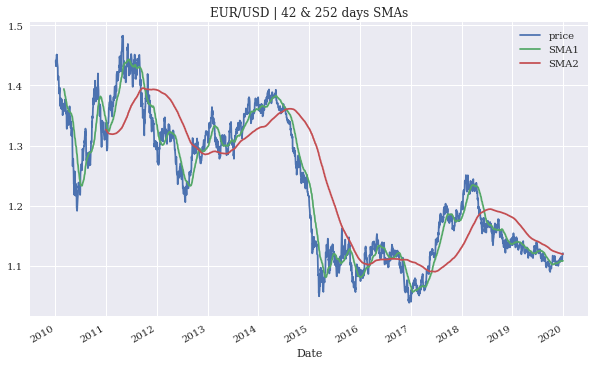

In [20]:
data.plot(title='EUR/USD | 42 & 252 days SMAs', figsize=(10, 6));

The next step is to generate signals, or rather market positionings, based on the relationship between the two SMAs. The rule is to _go long whenever the shorter SMA is above the longer one and vice versa_. For our purposes, we indicate a long position by 1 and a short position by –1.

Being able to directly compare two columns of the `DataFrame` object makes the implementation of the rule an affair of a single line of code only.

In [23]:
import numpy as np

In [28]:
# Implements the trading rule in vectorized fashion.
# np.where() produces +1 for rows where the expression is True
# and -1 for rows where the expression is False.
data['position'] = np.where(data['SMA1'] > data['SMA2'], 1, -1)

In [27]:
# Deletes all rows of the data set that contain at least one NaN value.
data.dropna(inplace=True)

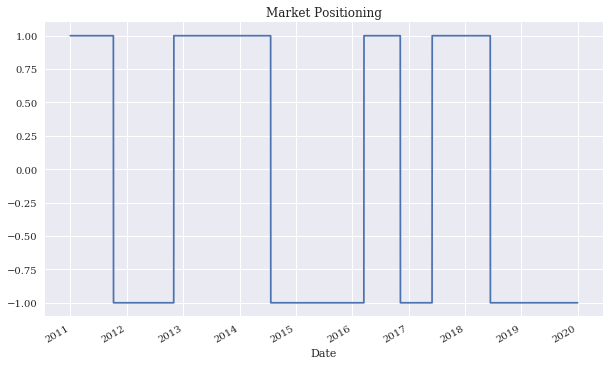

In [26]:
data['position'].plot(ylim=[-1.1, 1.1], title='Market Positioning', figsize=(10, 6))

To calculate the performance of the strategy, calculate the log returns based on the original financial time series next. The code to do this is again rather concise due to vectorization.

In [29]:
# Calculates the log returns in vectorized fashion over the price column.
data['returns'] = np.log(data['price'] / data['price'].shift(1))

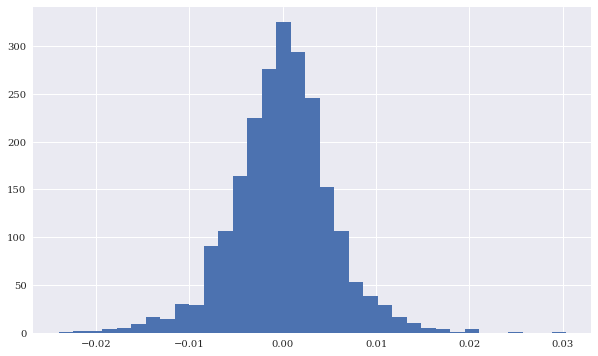

In [30]:
# Plots the log returns as a histogram (frequency distribution).
data['returns'].hist(bins=35, figsize=(10, 6))

Comparing the returns shows that the strategy books a win over the passive benchmark investment:

In [35]:
# Derives the log returns of the strategy given
# the positionings and market returns.
data['strategy'] = data['position'].shift(1) * data['returns']

In [36]:
# Sums up the single log return values for both the stock
# and the strategy (for illustration only).
data[['returns', 'strategy']].sum()

returns    -0.176731
strategy    0.253121
dtype: float64

In [38]:
# Applies the exponential function to the sum of the log
# returns to calculate the gross performance.
data[['returns', 'strategy']].sum().apply(np.exp)

returns     0.838006
strategy    1.288039
dtype: float64

Calculating the cumulative sum over time with `cumsum` and, based on this, the cumulative returns by applying the exponential function `np.exp()` gives a more comprehensive picture of how the strategy compares to the performance of the base financial instrument over time.

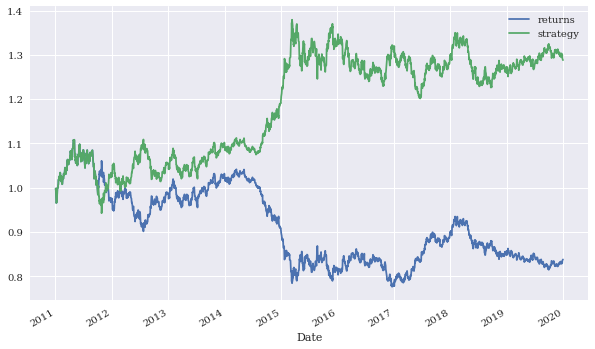

In [42]:
data[['returns', 'strategy']].cumsum(
    ).apply(np.exp).plot(figsize=(10, 6))